In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp
import pyinterp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7872648.datarmor0/parcels-502090/libparcels_random_11cd2047-831c-4b7c-b679-35c0341694c2.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=2
                 )
#
client = Client(cluster)

In [3]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [4]:
def interp_trajectories(df_sub,ds,v,part=None):
    """
    Interpolate Eulerian mean field over simulated drifters trajectories usin inverse distance weigthing method.
    
    Parameters:
    ----------
    df_sub : dask dataframe
    v : Variable to be interpolated
    Returns:
    ----------
    df_sub : input dask dataframe with an additional column of interpolated field
    """     
    mesh = pyinterp.RTree()
    #try:
    _dsi = ds.sel(time=df_sub.index.values).compute()#index
    if part:
        if part=='real':
            var = _dsi[v].real.values
        elif part=='imag':
            var = _dsi[v].imag.values
    else:
        var = _dsi[v].values
    #print(_dsi.XC.shape)
    mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                            _dsi.YC.values.flatten())).T,
                    var.flatten()
                )

    idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
            within=True,
            radius=None,
            k=4,  
            num_threads=0)

    df_sub[v+'_interp'] = idw_eta
   # except:
   #     df_sub[v+'_interp'] = np.nan

    return  df_sub

In [5]:
def interp_sig(_df, dsi,v,time,method=None,part=None):
    idw_eta, neighbors = [],[]
    idw_eta_mid, neighbors_mid = [],[]
    
    for it in range(0,_df.index.values.size):
    #for t in time
        mesh = pyinterp.RTree()
        _dsi = dsi.isel(time=it)#
        if part=='real':
            var = np.real(_dsi[v].values)
        elif part=='imag':
            var = np.imag(_dsi[v].values)
        elif part=='abs':
            var = np.abs(_dsi[v].values)
        elif part=='angle':
            var = np.angle(_dsi[v].values)
        else:
            var = _dsi[v].values
        mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                                _dsi.YC.values.flatten())).T,
                         var.flatten(),
                        )
        if method:
            idw_eta.append(mesh.radial_basis_function(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,  
                    num_threads=0,
                    rbf=method)[0])
            neighbors.append(mesh.radial_basis_function(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,
                    num_threads=0,
                    rbf=method)[1])
            idw_eta_mid.append(mesh.radial_basis_function(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4, 
                        num_threads=0,
                        rbf=method)[0])
            neighbors_mid.append(mesh.radial_basis_function(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4,  
                        num_threads=0,
                        rbf=method)[1])
        else:    
            idw_eta.append(mesh.inverse_distance_weighting(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,  
                    num_threads=0)[0])
            neighbors.append(mesh.inverse_distance_weighting(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,  
                    num_threads=0)[1])
            idw_eta_mid.append(mesh.inverse_distance_weighting(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4,  
                        num_threads=0)[0])
            neighbors_mid.append(mesh.inverse_distance_weighting(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4,  
                        num_threads=0)[1])
    interp = idw_eta[0]
    for i in idw_eta[1:]:
        interp = np.insert(i,-1,interp)
    interp_mid = idw_eta_mid[0]
    for i in idw_eta_mid[1:]:
        interp_mid = np.insert(i,-1,interp_mid)
    return interp, interp_mid

In [7]:
isel = dict(face=7)
sel = dict(i=slice(2700,2900), j=slice(2900,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
sel_interp = dict(i=slice(2500,2900), j=slice(2300,3400))

In [8]:
ds = xr.merge([xr.open_zarr(ut.work_data_dir+'rechunked/SSU.zarr'),xr.open_zarr(ut.work_data_dir+'rechunked/SSV.zarr'),
               xr.open_zarr(ut.work_data_dir+'rechunked/Eta.zarr')
              ])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

In [9]:
dsp = ds.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10
dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.drop(['SSU','SSV']).persist()

In [10]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2","K1","O1","M4","S4")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

lat_mean = dsp.lat.mean().values

f0 = 2*7.2921*1e-5
f = f0*np.sin(2*np.pi*lat_mean/360)*3600*24/(2*np.pi)
f

1.2746172538745189

In [11]:
def wrap_filter(_ds,om,Tw,dband,V,dt=dt):
    h = sp.generate_filter(om, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True).persist()
        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real']=ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag']=ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])
    return ds_hat,h

In [12]:
V = ['zonal_velocity','meridional_velocity'
    ]
Tw = 30
dband=0.2 #half bandwidth

ds_hat,h = wrap_filter(dsp,omega,Tw,dband,V)
ds_hat = xr.merge([ds_hat,dsp])

ds_hat_f,h_f = wrap_filter(dsp,f,Tw,dband,V)
ds_hat_f = xr.merge([ds_hat_f,dsp])


In [13]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time_mean'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

trajectory        lat         lon    z  zonal_velocity  \
time                                                                 
2011-11-15    39000000  57.835732 -178.867081  0.0             0.0   
2011-11-15    39000001  58.429878 -178.871994  0.0             0.0   
2011-11-15    39000002  59.018066 -178.879623  0.0             0.0   
2011-11-15    39000003  59.600288 -178.890015  0.0             0.0   
2011-11-15    39000004  60.176525 -178.903275  0.0             0.0   

            meridional_velocity  sea_level  temperature  salinity  Eta_interp  \
time                                                                            
2011-11-15                  0.0        0.0          0.0       0.0    0.060997   
2011-11-15                  0.0        0.0          0.0       0.0    0.075155   
2011-11-15                  0.0        0.0          0.0       0.0    0.169278   
2011-11-15                  0.0        0.0          0.0       0.0    0.242839   
2011-11-15                  0.0        0.0          0.0       0.0    0.222071   

            SSU_interp  SST_interp  SSV_interp  SSS_interp  
time                                                        
2011-11-15   -0.002461    4.279537   -0.006017   33.194778  
2011-11-15   -0.091730    4.326020    0.050204   33.139637  
2011-11-15   -0.203138    4.161501    0.209887   32.961617  
2011-11-15   -0.075768    3.679666    0.064889   32.712219  
2011-11-15   -0.006189    3.151162    0.057710   32.573410

In [14]:
df = df.drop(columns=['temperature','salinity','Eta_interp','SSU_interp','SSV_interp','SST_interp','SSS_interp'])
lonmin,lonmax,latmin,latmax = dsp.lon.min().values,dsp.lon.max().values,dsp.lat.min().values,dsp.lat.max().values

In [15]:
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
#traj = _df.index.drop_duplicates(keep='first').compute()#["index"]

df_selected = df[df.trajectory.isin(traj)]

In [16]:
def remove_duplicates(df):
    df = df.reset_index().drop_duplicates('time').sort_values('time').set_index('time')
    dt_df = df.index[1:]-df.index[:-1]
    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

def filt_L(v, h,columns,om, hilbert=False):
    vc = v.copy()
    #vc = vc.groupby(vc.index).first()#.drop_duplicates
    #vc = vc.groupby(level=df1.index.names).last()
    for V in columns:
        vc[V+'_hat'] = convolve(vc[V],h=h,hilbert=hilbert)
    time = np.arange(0,vc.index.size*dt,dt)#.compute()
    exp = np.exp(-1j*om*2*np.pi*time)
    for V in columns:
        vc[V+'_demodulated'] = vc[V+'_hat']*exp
    return vc

In [17]:
Tw = Tw
dband= dband
omega = omega #(omega_M2+omega_S2)/2
hL = h#sp.generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)



In [18]:
df_selected = df_selected.groupby('trajectory').apply(remove_duplicates
                                                      ).drop(columns='trajectory').reset_index().set_index('time').persist()
df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],omega,hilbert=True).persist()
#df_filtered = df_filtered.repartition(npartitions=10).persist()

df_filtered = df_filtered.drop(columns='trajectory').reset_index().sort_values('time').set_index('time').persist()

<ipython-input-18-714acc802288>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_selected = df_selected.groupby('trajectory').apply(remove_duplicates
<ipython-input-18-714acc802288>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,hL,['zonal_velocity','meridional_velocity'],omega,hilbert=True).persist()


In [19]:
df_filtered_f = df_selected.groupby('trajectory').apply(filt_L,h_f,['zonal_velocity','meridional_velocity'],f,hilbert=True).persist()
#df_filtered = df_filtered.repartition(npartitions=10).persist()

df_filtered_f = df_filtered_f.drop(columns='trajectory').reset_index().sort_values('time').set_index('time').persist()

<ipython-input-19-fdbff4322674>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered_f = df_selected.groupby('trajectory').apply(filt_L,h_f,['zonal_velocity','meridional_velocity'],f,hilbert=True).persist()


In [20]:
dt = 1/24
t_mid = int(360/dt//2)
dtime = int(5/dt)

dsi = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))
dsi_f = ds_hat_f.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))

_df1 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==37000174].compute()
_df2 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000248].compute()

_df1_f = df_filtered_f.loc[dsi.time.values][df_filtered_f.loc[dsi.time.values].trajectory==37000174].compute()
_df2_f = df_filtered_f.loc[dsi.time.values][df_filtered_f.loc[dsi.time.values].trajectory==38000248].compute()

In [21]:
V = ['zonal_velocity','meridional_velocity']
interp,interp_mid,interp2,interp_mid2 = {},{},{},{}

In [24]:
for v in V:
    for part in ['real','imag']:
        interp[v+'_hat'+'_'+part],interp_mid[v+'_hat'+'_'+part] = interp_sig(_df1,dsi,v+'_hat',
                                                                             _df1.index.values,part=part)
        interp2[v+'_hat'+'_'+part],interp_mid2[v+'_hat'+'_'+part] = interp_sig(_df2,dsi,v+'_hat',
                                                                               _df2.index.values,part=part)
        interp[v+'_demodulated'+'_'+part],interp_mid[v+'_demodulated'+'_'+part] = interp_sig(_df1,dsi,v+'_demodulated',
                                                                                             _df1.index.values,part=part)
        interp2[v+'_demodulated'+'_'+part],interp_mid2[v+'_demodulated'+'_'+part] = interp_sig(_df2,dsi,v+'_demodulated',
                                                                                               _df2.index.values,part=part)

In [22]:
V = ['zonal_velocity','meridional_velocity']
for v in V:
    interp[v],interp_mid[v] = interp_sig(_df1,dsi,v,_df1.index.values,part=None)
    interp2[v],interp_mid2[v] = interp_sig(_df2,dsi,v,_df2.index.values,part=None)

In [23]:
V = ['zonal_velocity_hat','meridional_velocity_hat']
for v in V:
    interp[v+'_abs'],interp_mid[v+'_abs'] = interp_sig(_df1,dsi,v,_df1.index.values,part='abs')
    interp2[v+'_abs'],interp_mid2[v+'_abs'] = interp_sig(_df2,dsi,v,_df2.index.values,part='abs')
    interp[v+'_angle'],interp_mid[v+'_angle'] = interp_sig(_df1,dsi,v,_df1.index.values,part='angle')
    interp2[v+'_angle'],interp_mid2[v+'_angle'] = interp_sig(_df2,dsi,v,_df2.index.values,part='angle')

In [24]:
V = ['zonal_velocity_demodulated','meridional_velocity_demodulated']
for v in V:
    interp[v+'_abs'],interp_mid[v+'_abs'] = interp_sig(_df1,dsi,v,_df1.index.values,part='abs')
    interp2[v+'_abs'],interp_mid2[v+'_abs'] = interp_sig(_df2,dsi,v,_df2.index.values,part='abs')
    interp[v+'_angle'],interp_mid[v+'_angle'] = interp_sig(_df1,dsi,v,_df1.index.values,part='angle')
    interp2[v+'_angle'],interp_mid2[v+'_angle'] = interp_sig(_df2,dsi,v,_df2.index.values,part='angle')

In [38]:
V = ['zonal_velocity','meridional_velocity']
interp_f,interp_mid_f,interp2_f,interp_mid2_f = {},{},{},{}
for v in V:
    for part in ['real','imag']:
        interp_f[v+'_hat'+'_'+part],interp_mid_f[v+'_hat'+'_'+part] = interp_sig(_df1_f,dsi_f,v+'_hat',
                                                                             _df1.index.values,part=part)
        interp2_f[v+'_hat'+'_'+part],interp_mid2_f[v+'_hat'+'_'+part] = interp_sig(_df2_f,dsi_f,v+'_hat',
                                                                               _df2.index.values,part=part)
        interp_f[v+'_demodulated'+'_'+part],interp_mid_f[v+'_demodulated'+'_'+part] = interp_sig(_df1_f,dsi_f
                                                                                                 ,v+'_demodulated',
                                                                                             _df1.index.values,part=part)
        interp2_f[v+'_demodulated'+'_'+part],interp_mid2_f[v+'_demodulated'+'_'+part] = interp_sig(_df2_f,dsi_f
                                                                                                   ,v+'_demodulated',
                                                                                               _df2.index.values,part=part)

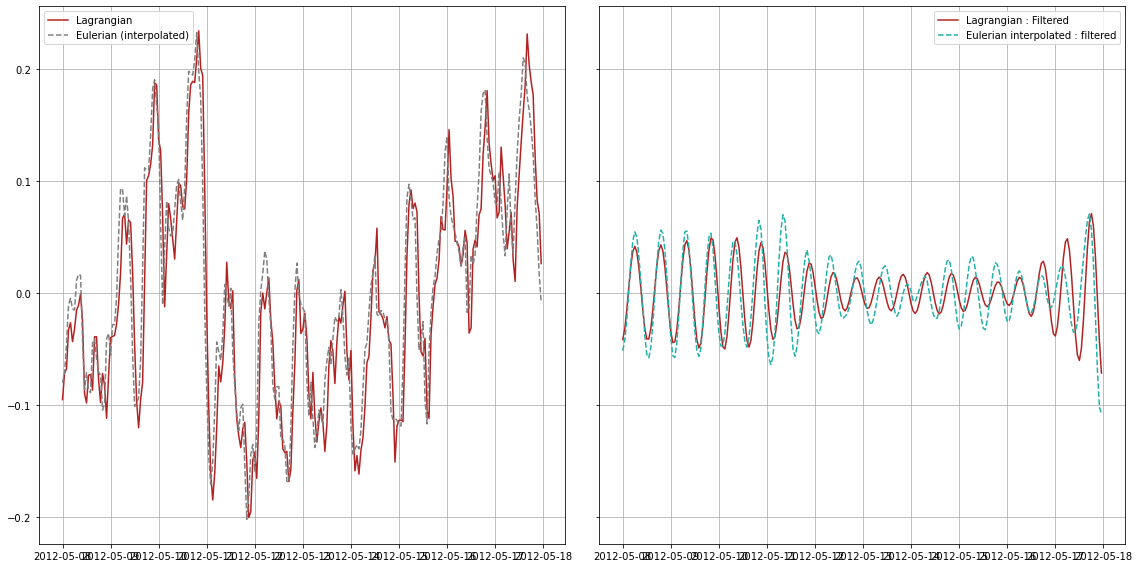

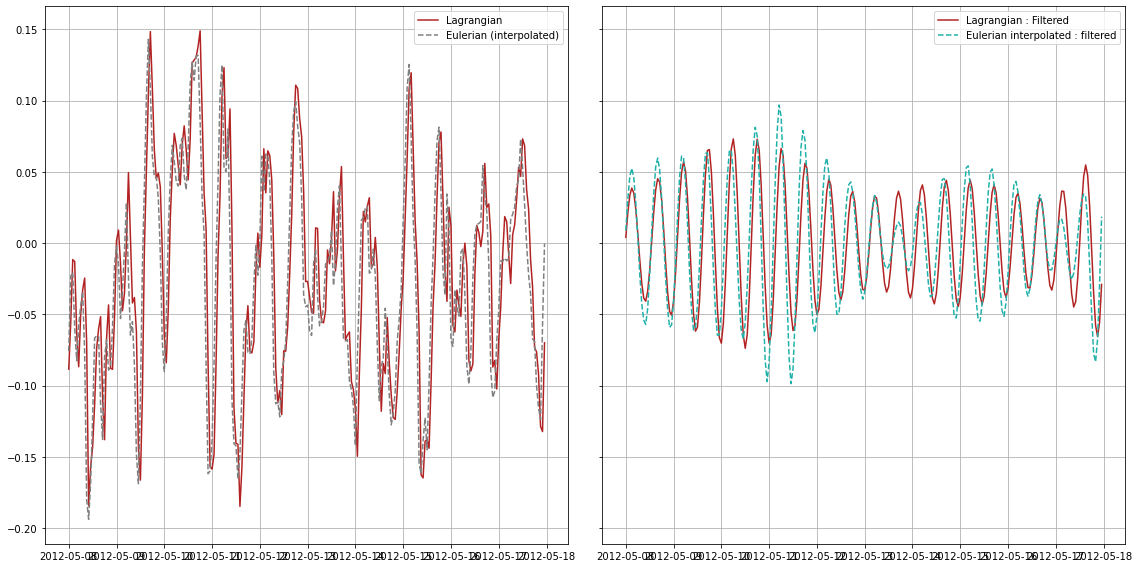

In [30]:
time = _df2.index.values
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df2[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp2[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp2[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df2[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp2[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp2[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

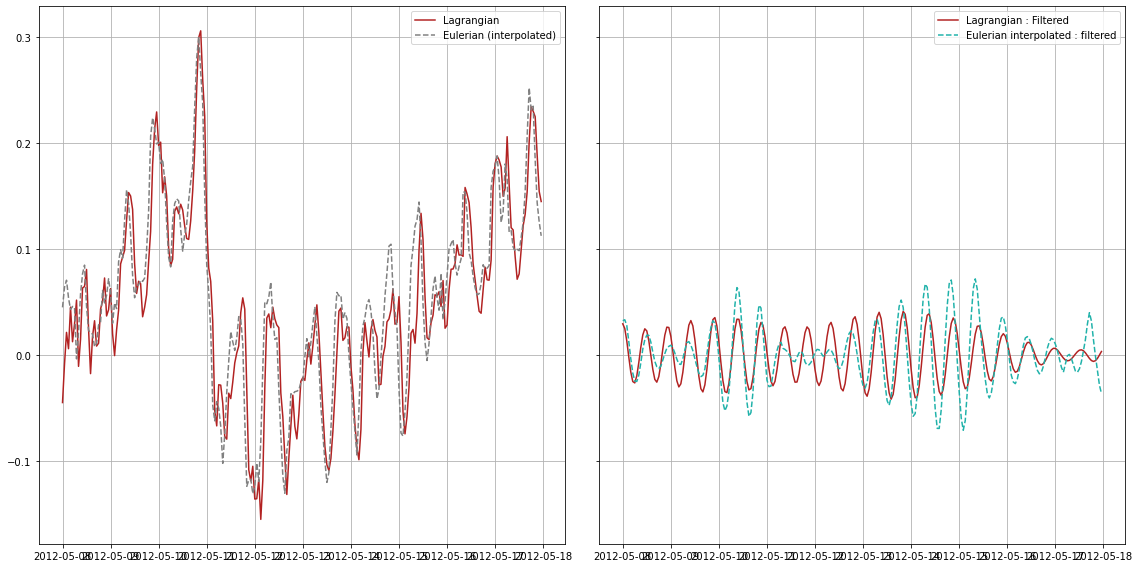

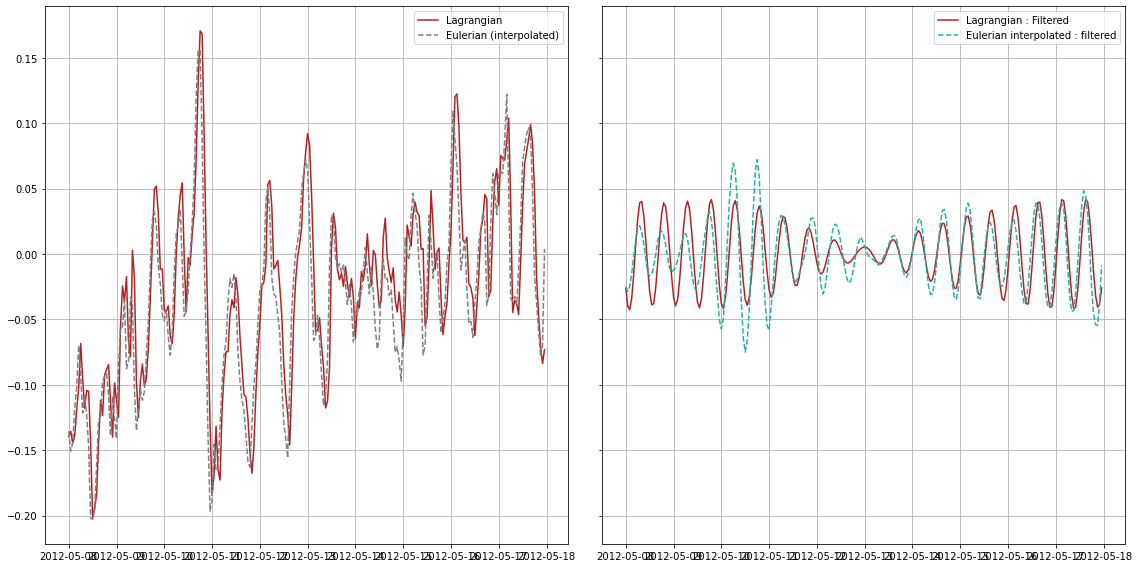

In [31]:
time = _df1.index.values
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df1[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df1[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

Text(0.5, 0.98, 'Imaginary part')

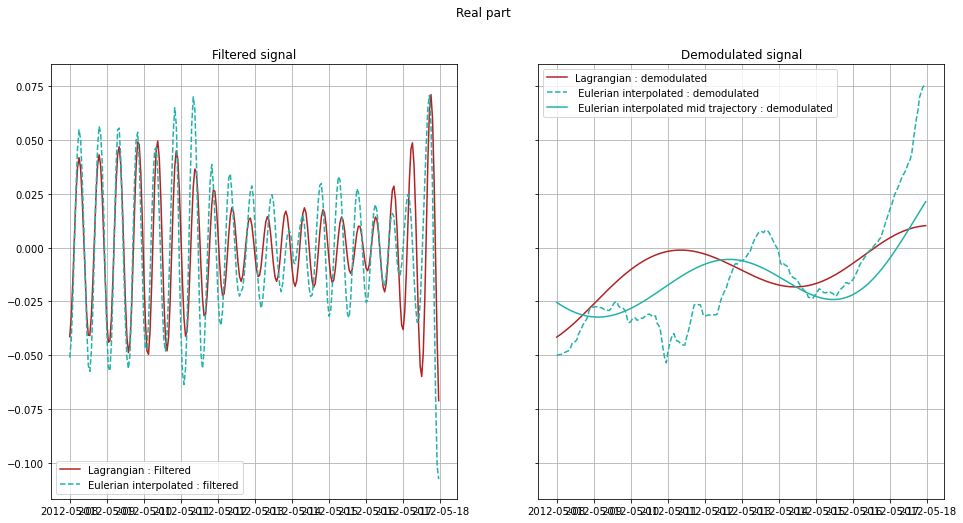

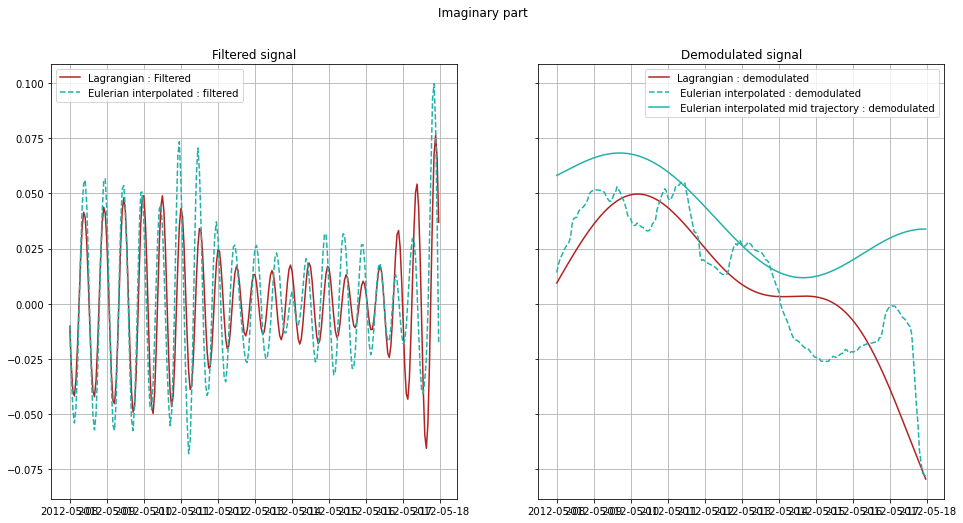

In [34]:
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.imag(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_hat_imag'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

Text(0.5, 0.98, 'Imaginary part')

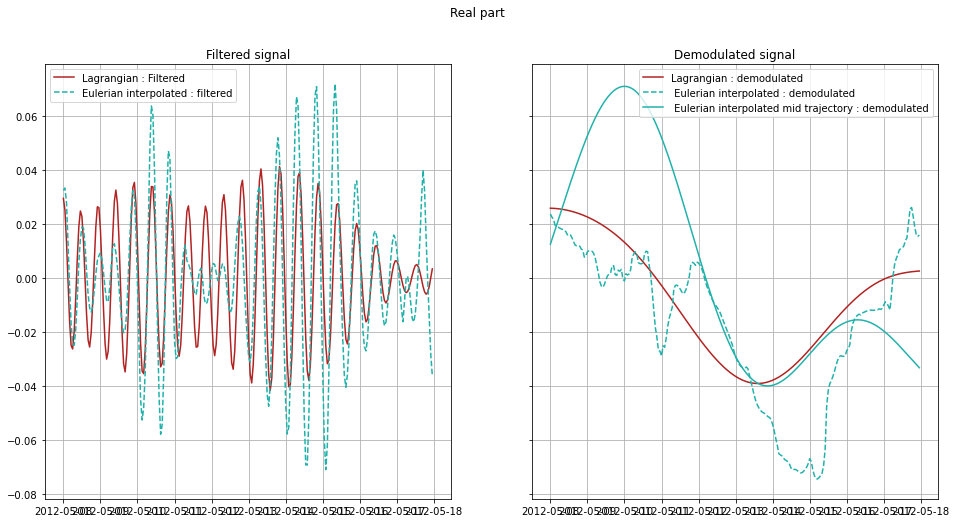

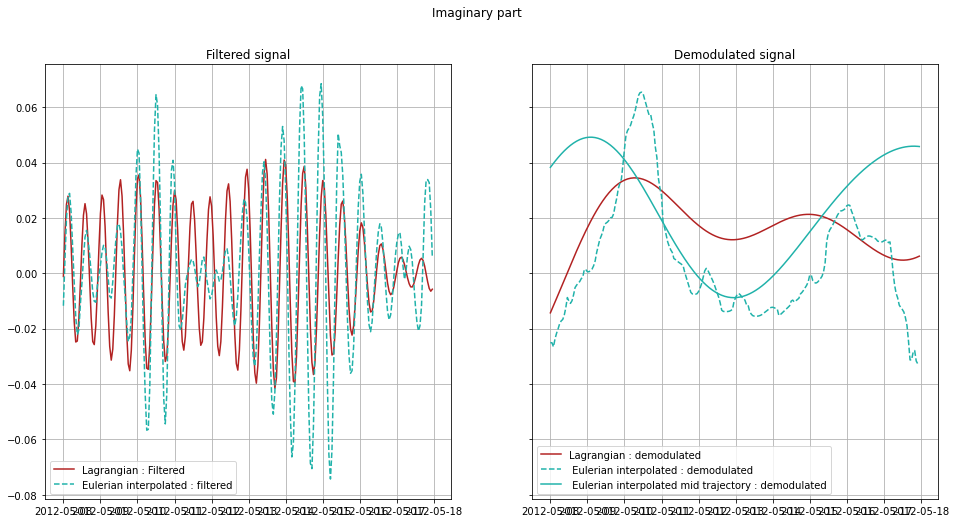

In [35]:
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.imag(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_hat_imag'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

Text(0.5, 0.98, 'Imaginary part')

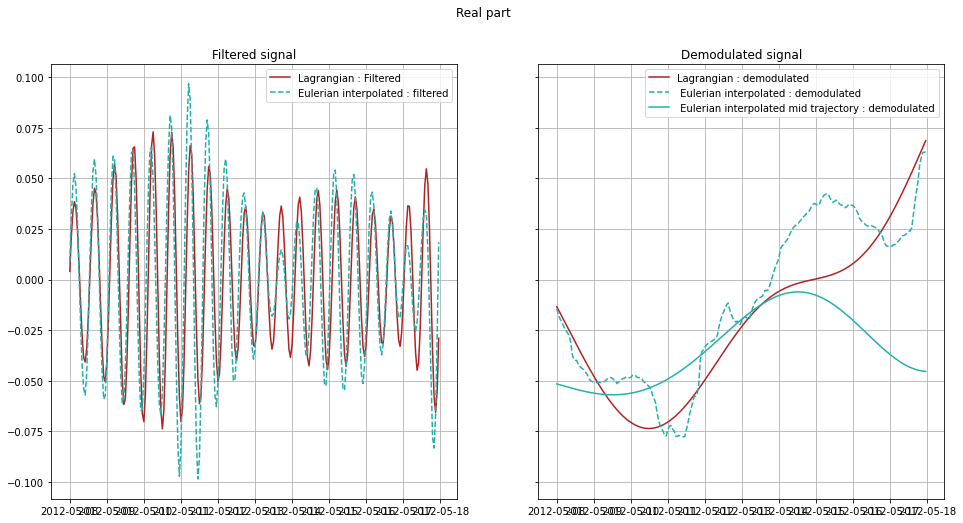

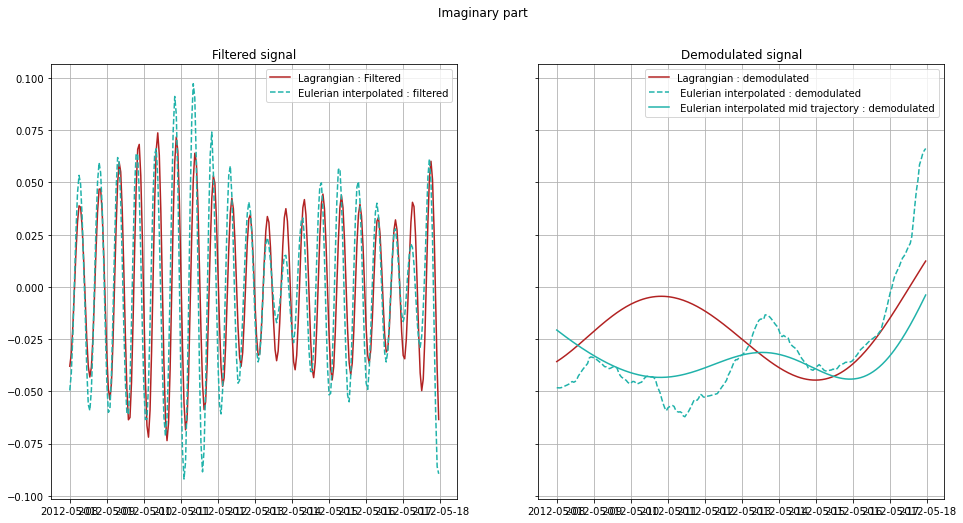

In [36]:
v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.imag(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_hat_imag'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

Text(0.5, 0.98, 'Imaginary part')

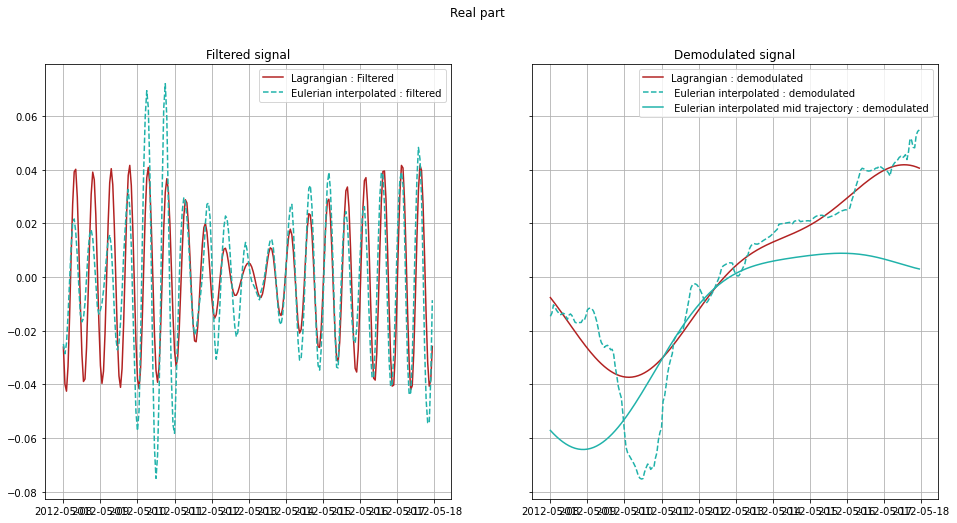

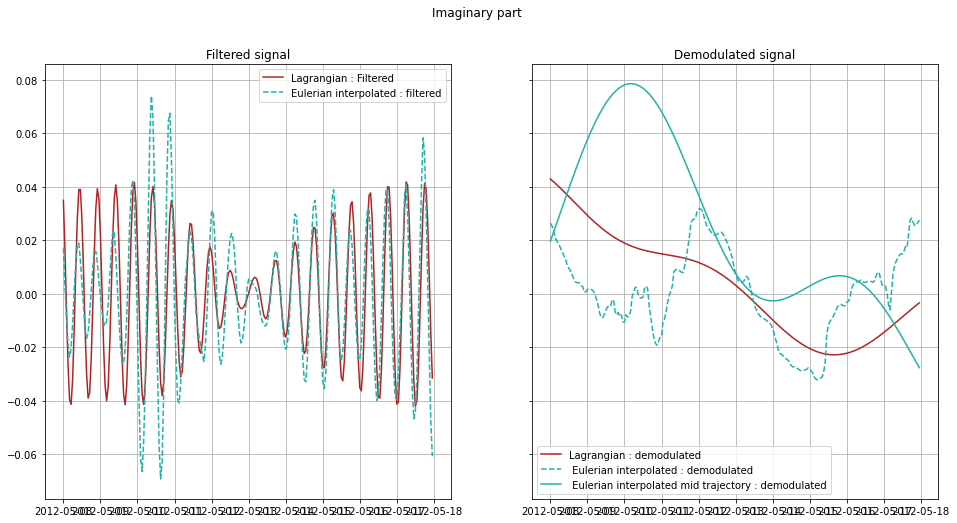

In [37]:
v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.imag(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_hat_imag'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

Text(0.5, 0.98, 'meridional_velocity')

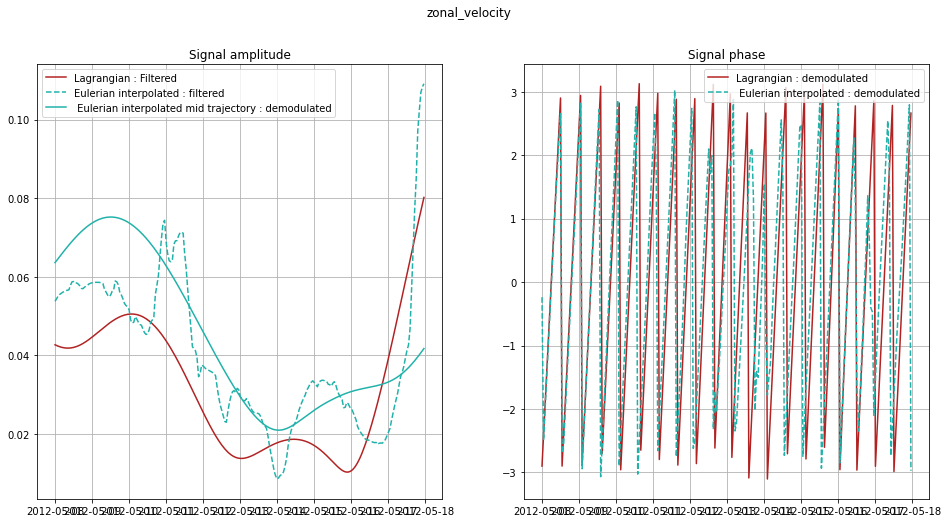

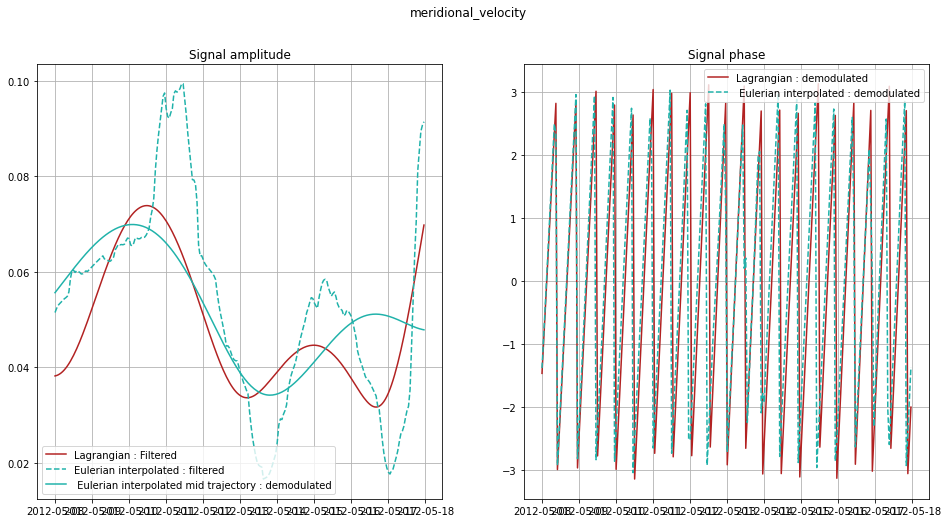

In [62]:
# amplitude and phase of filtered signal:
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_hat_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_hat_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid2[v+'_hat_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df2[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_hat_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_hat_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid2[v+'_hat_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

Text(0.5, 0.98, 'meridional_velocity')

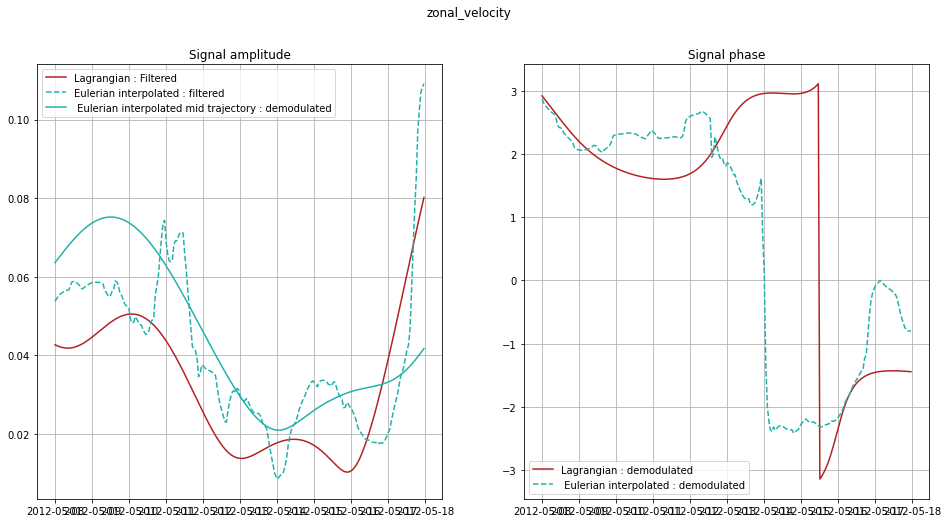

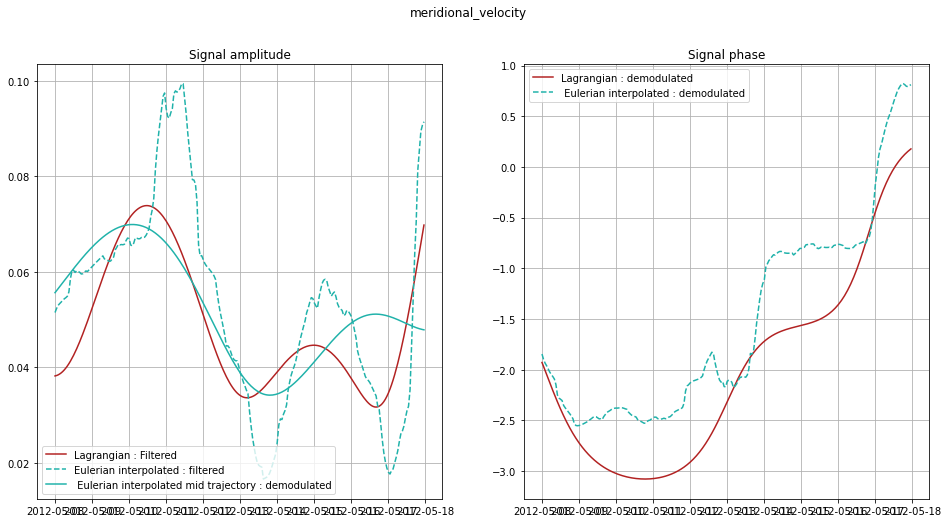

In [26]:
# amplitude and phase of filtered signal:
time = _df2.index.values

v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_demodulated_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_demodulated_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid2[v+'_demodulated_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df2[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2[v+'_demodulated_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2[v+'_demodulated_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid2[v+'_demodulated_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

Text(0.5, 0.98, 'meridional_velocity')

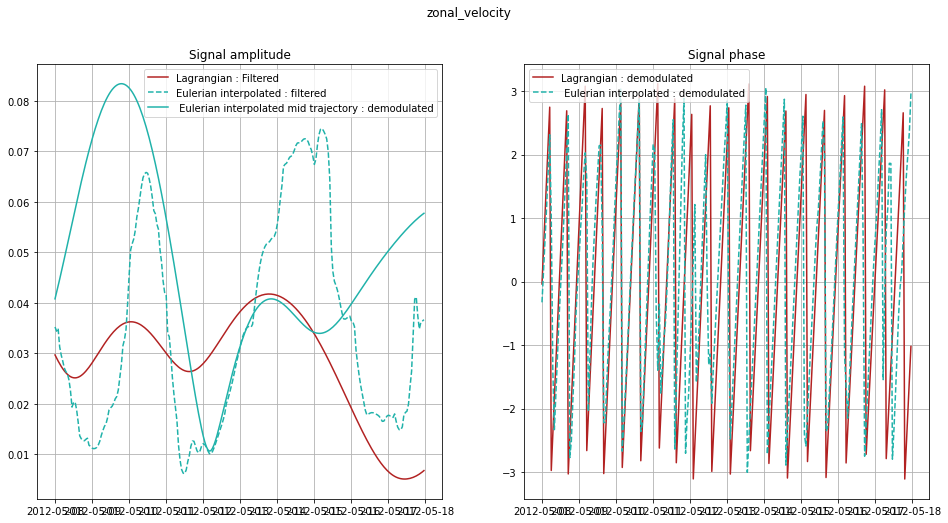

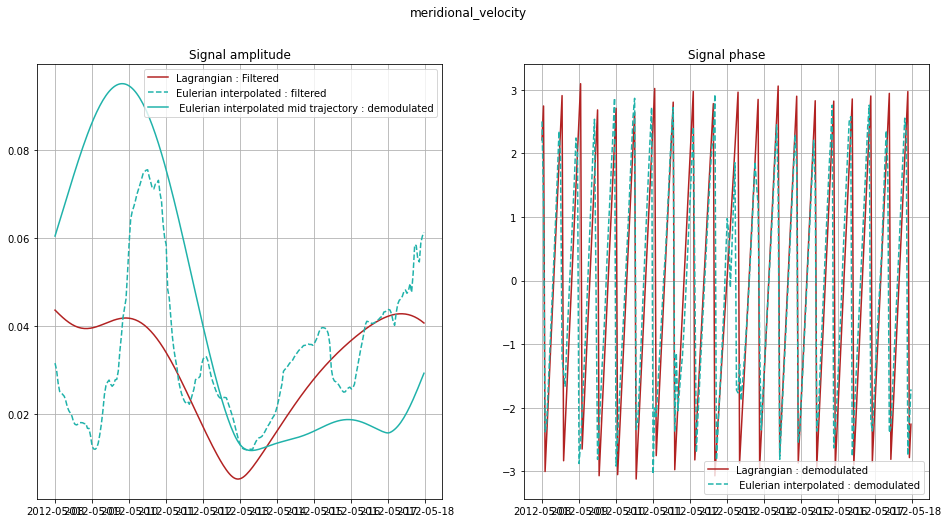

In [61]:
# amplitude and phase of filtered signal:
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_hat_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_hat_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid[v+'_hat_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_hat_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_hat_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid[v+'_hat_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

Text(0.5, 0.98, 'meridional_velocity')

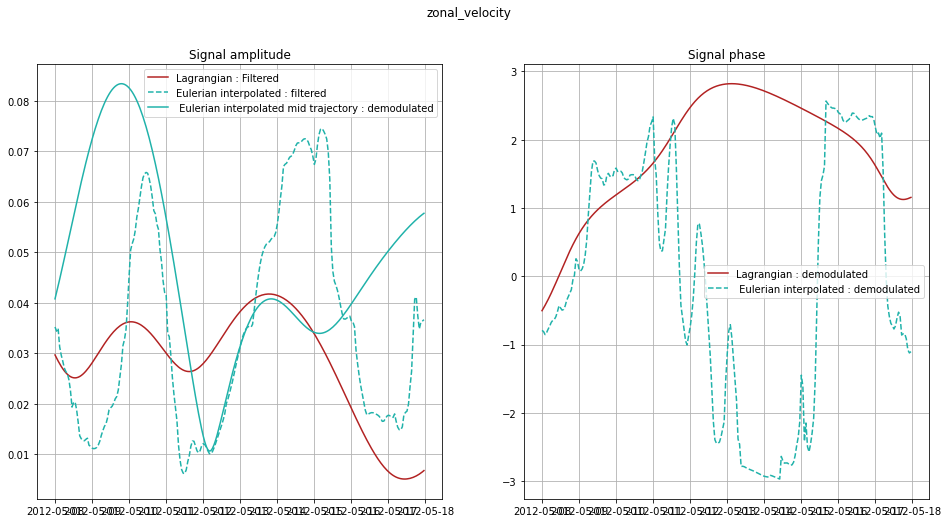

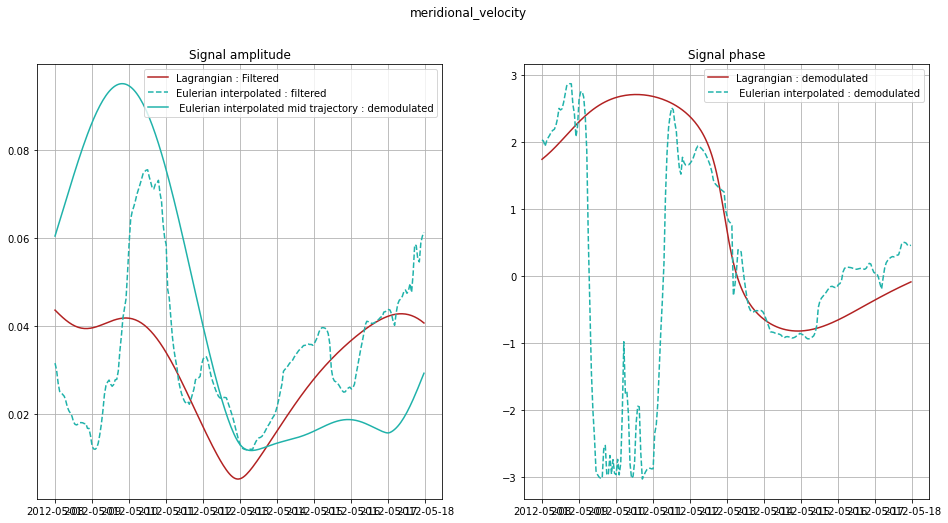

In [27]:
# amplitude and phase of filtered signal:
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_demodulated_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_demodulated_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid[v+'_demodulated_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)

#ax[0].plot(time,np.real(_df1[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[0].plot(time,np.abs(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.angle(_df1[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp[v+'_demodulated_abs'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp[v+'_demodulated_angle'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[0].plot(time,interp_mid[v+'_demodulated_abs'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Signal amplitude');ax[1].set_title('Signal phase');
fig.suptitle(v)

#### Near-inertial band

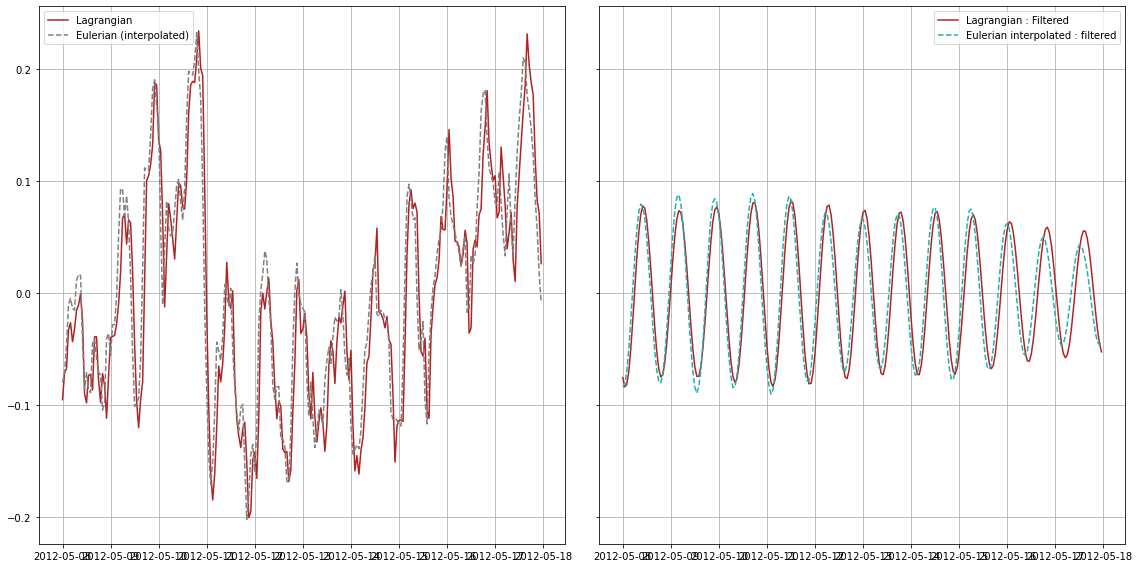

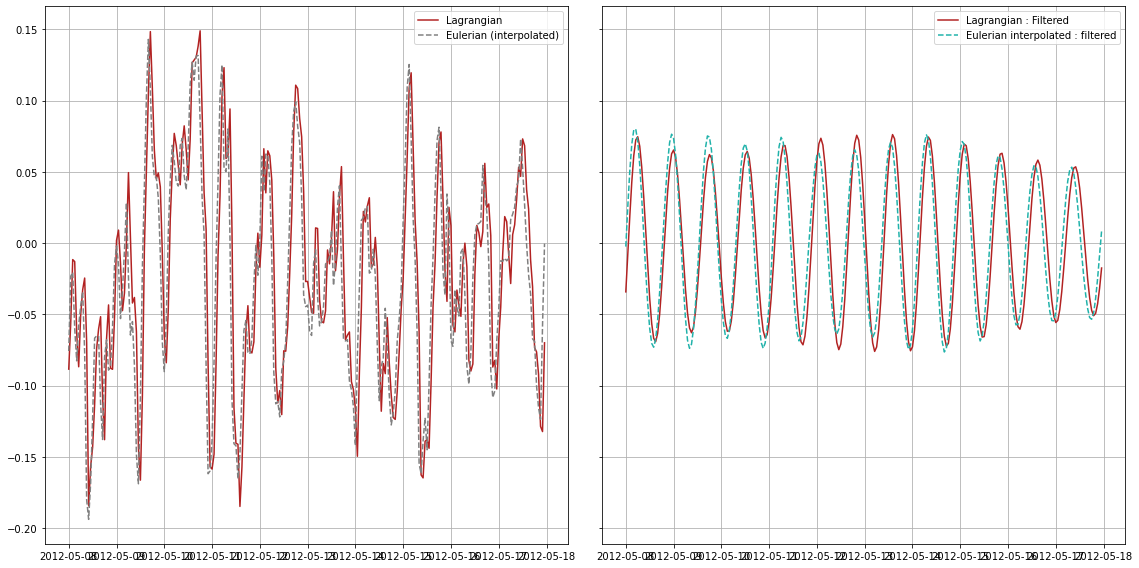

In [40]:
time = _df2.index.values
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df2_f[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp2[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df2_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp2_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df2_f[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp2[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df2_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp2_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

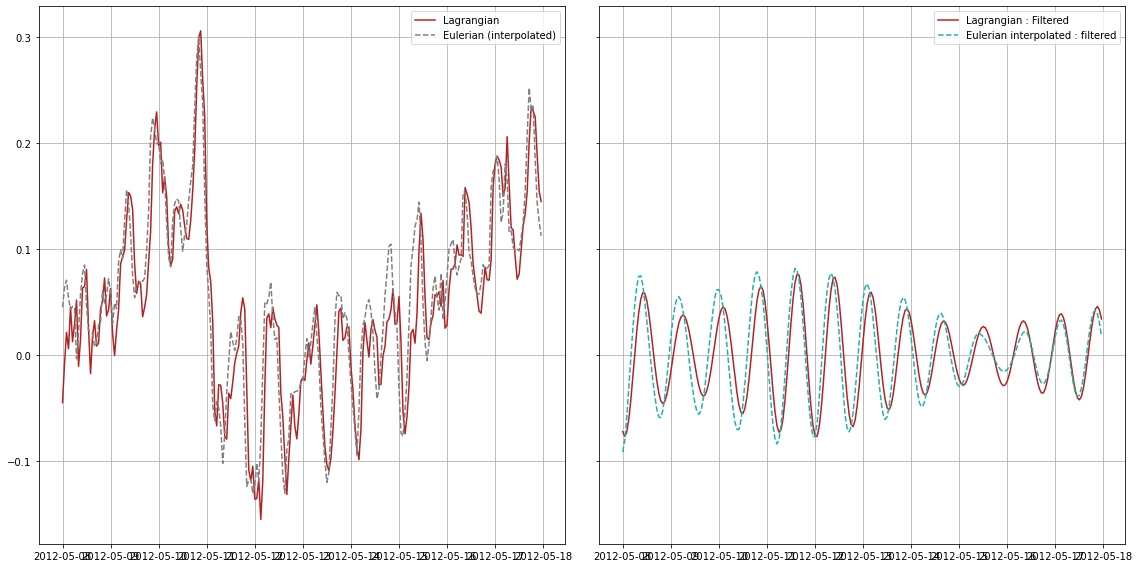

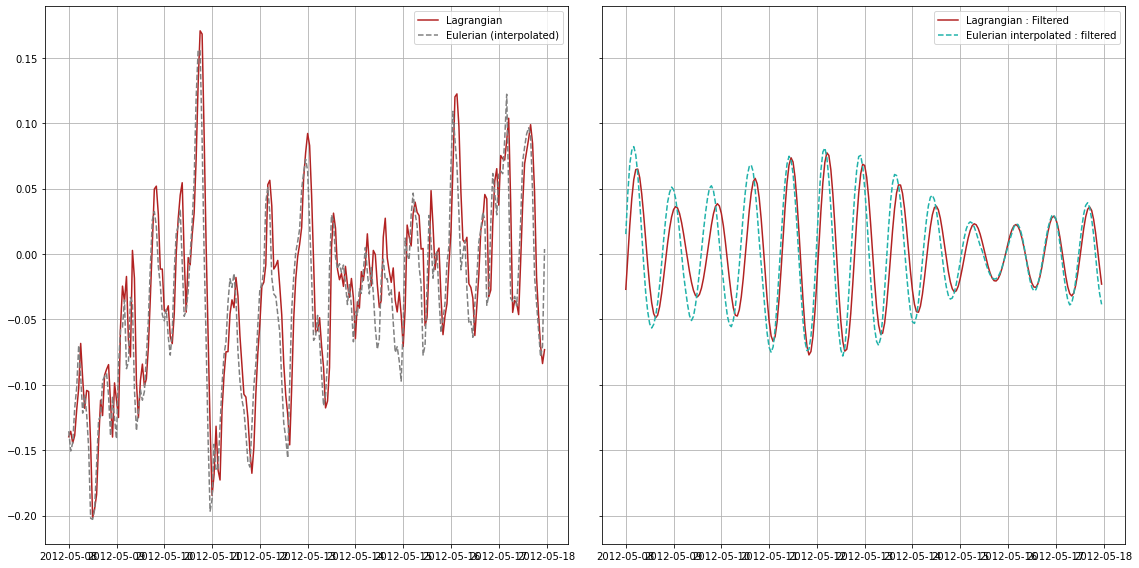

In [45]:
time = _df1.index.values
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df1_f[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df1_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
ax[0].plot(time,_df1_f[v],c='firebrick',linestyle='-',label='Lagrangian')
ax[0].plot(time,interp[v],c='grey',linestyle='--',label='Eulerian (interpolated)')

ax[1].plot(time,np.real(_df1_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,interp_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[0].legend();ax[0].grid()
#ax[0].axvline(time[time.size//2],c='k',linestyle='--',linewidth=1)
ax[1].legend();ax[1].grid()
fig.tight_layout()

Text(0.5, 0.98, 'Imaginary part')

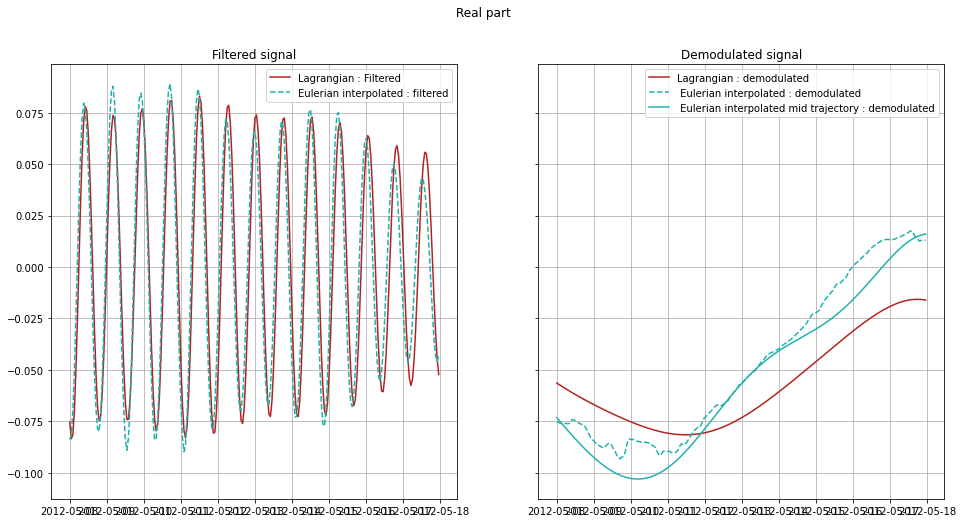

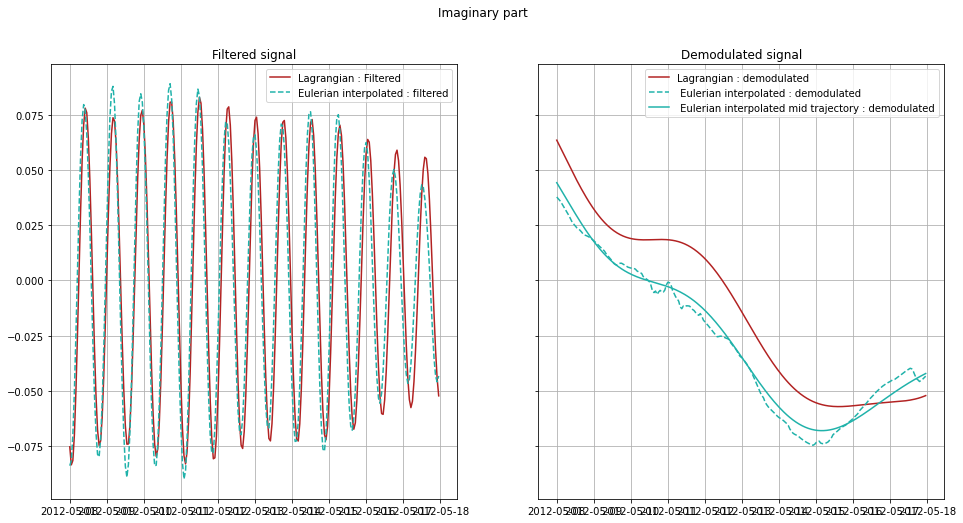

In [41]:
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df2_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df2_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2_f[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2_f[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df2_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df2_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

Text(0.5, 0.98, 'Imaginary part')

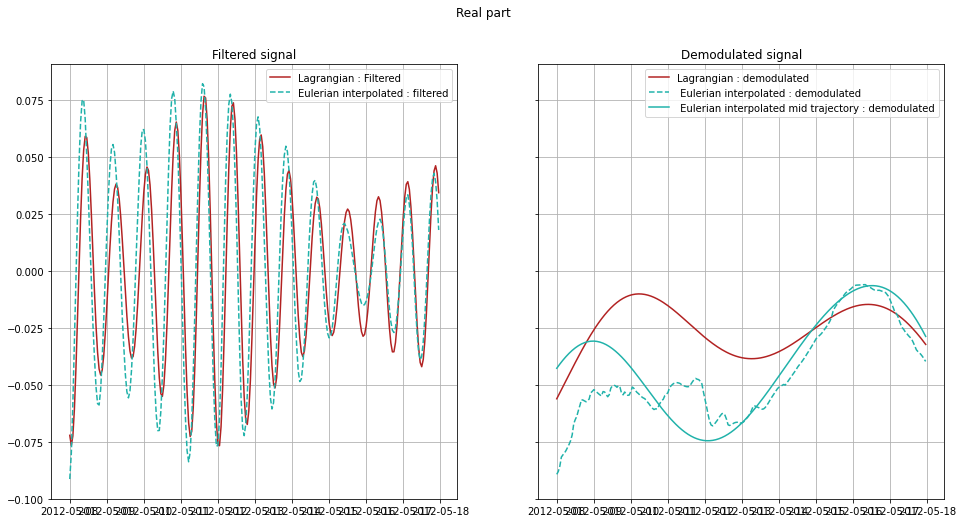

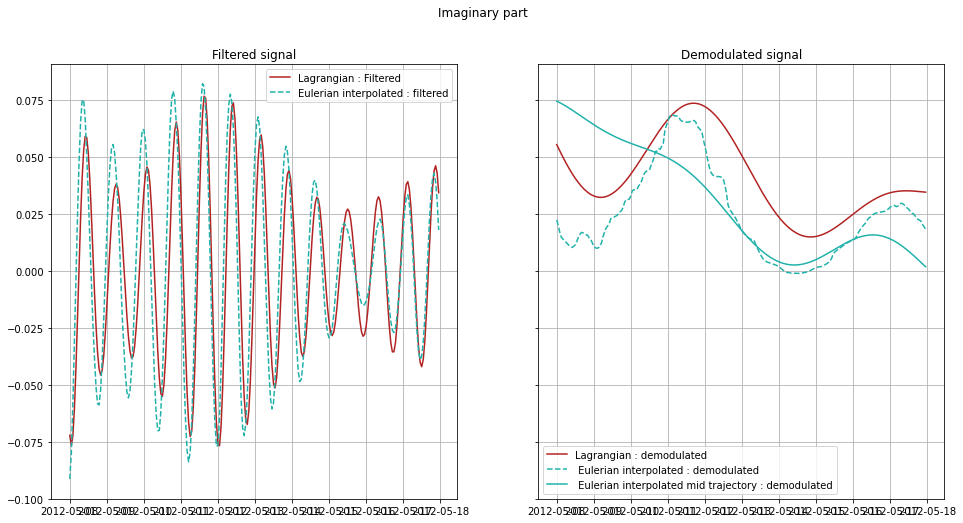

In [44]:
v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df1_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df1_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp_f[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid_f[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'zonal_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df1_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df1_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

Text(0.5, 0.98, 'Imaginary part')

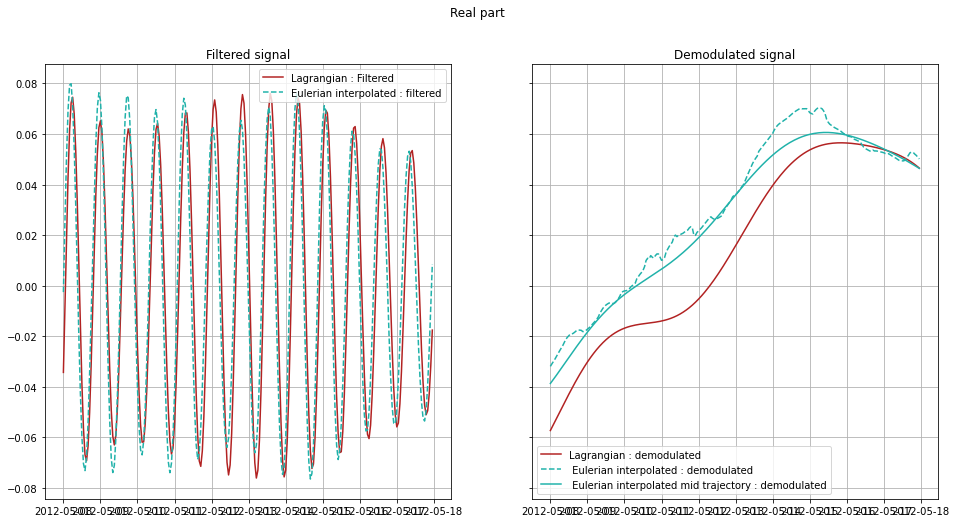

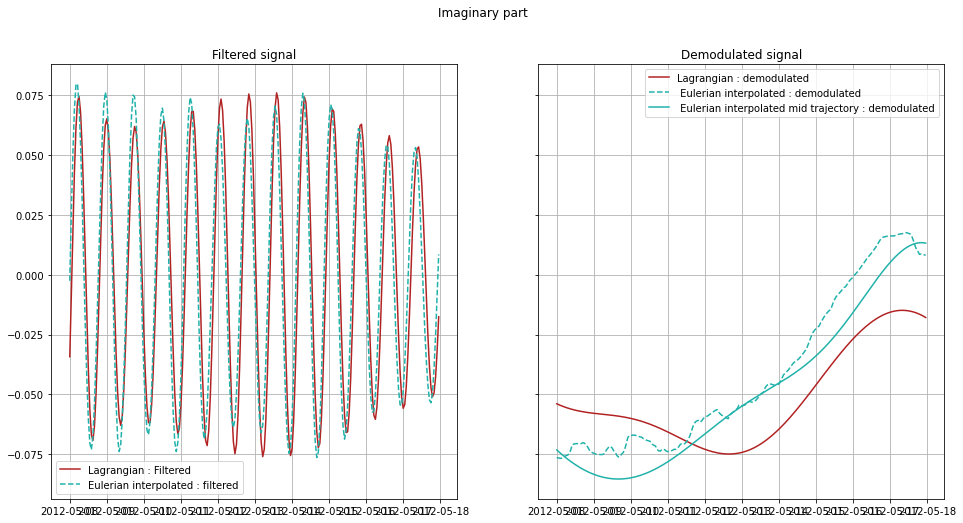

In [42]:
v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df2_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df2_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2_f[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2_f[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df2_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df2_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp2_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp2_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid2_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

Text(0.5, 0.98, 'Imaginary part')

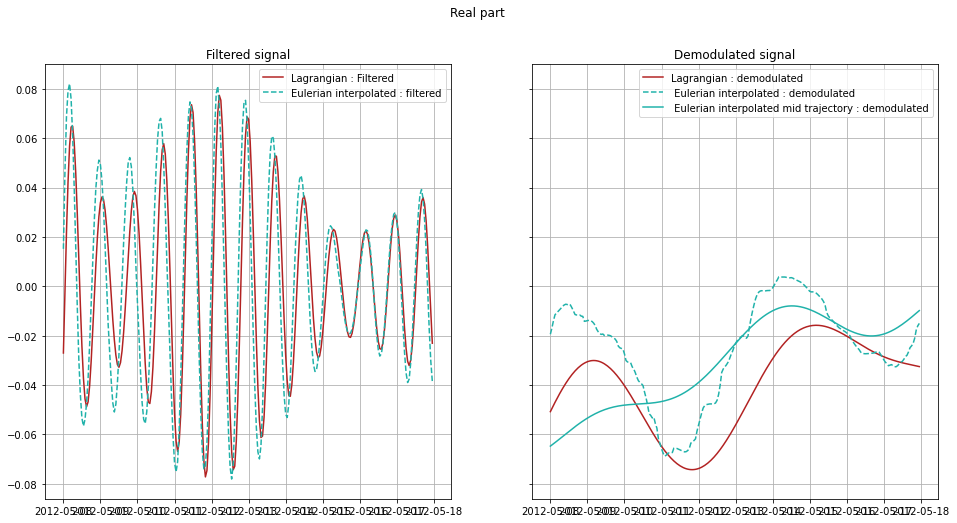

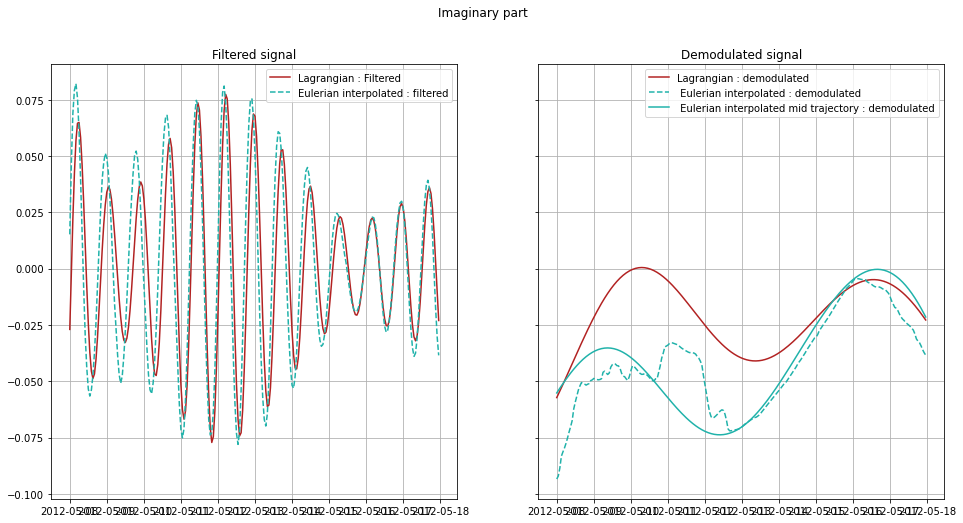

In [43]:
v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df1_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.real(_df1_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp_f[v+'_demodulated_real'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid_f[v+'_demodulated_real'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Real part')

v = 'meridional_velocity'
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)

ax[0].plot(time,np.real(_df1_f[v+'_hat']),c='firebrick',linestyle='-',label='Lagrangian : Filtered')
ax[1].plot(time,np.imag(_df1_f[v+'_demodulated']),c='firebrick',linestyle='-',label='Lagrangian : demodulated')

ax[0].plot(time,interp_f[v+'_hat_real'],c='lightseagreen',linestyle='--',label='Eulerian interpolated : filtered')
ax[1].plot(time,interp_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='--',label=' Eulerian interpolated : demodulated')
ax[1].plot(time,interp_mid_f[v+'_demodulated_imag'],c='lightseagreen',linestyle='-',label=' Eulerian interpolated mid trajectory : demodulated')

ax[0].legend();ax[0].grid()
ax[1].legend();ax[1].grid()
ax[0].set_title('Filtered signal');ax[1].set_title('Demodulated signal');
fig.suptitle('Imaginary part')

In [27]:
df_filtered = df_filtered.reset_index().persist()

In [29]:
df_filtered = df_filtered.repartition(npartitions=10).persist()



In [58]:
_dsi = ds_hat.sel(time=df_filtered.time.values.compute()[0])

In [59]:
_dsi

<xarray.Dataset>
Dimensions:                               (i: 101, j: 101)
Coordinates:
  * i                                     (i) int64 2700 2702 2704 ... 2898 2900
  * j                                     (j) int64 2900 2902 2904 ... 3098 3100
    face                                  int64 7
    time                                  datetime64[ns] 2011-11-15
    XC                                    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    YC                                    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    Depth                                 (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    CS                                    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    SN                                    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    rA                                    (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    lon                                   (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
    lat                                   (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
Data variables:
    zonal_velocity_hat                    (j, i) complex128 dask.array<chunksize=(86, 90), meta=np.ndarray>
    zonal_velocity_demodulated            (j, i) complex128 dask.array<chunksize=(86, 90), meta=np.ndarray>
    zonal_velocity_demodulated_real       (j, i) float64 dask.array<chunksize=(86, 90), meta=np.ndarray>
    zonal_velocity_demodulated_imag       (j, i) float64 dask.array<chunksize=(86, 90), meta=np.ndarray>
    meridional_velocity_hat               (j, i) complex128 dask.array<chunksize=(86, 90), meta=np.ndarray>
    meridional_velocity_demodulated       (j, i) complex128 dask.array<chunksize=(86, 90), meta=np.ndarray>
    meridional_velocity_demodulated_real  (j, i) float64 dask.array<chunksize=(86, 90), meta=np.ndarray>
    meridional_velocity_demodulated_imag  (j, i) float64 dask.array<chunksize=(86, 90), meta=np.ndarray>
    Eta                                   (j, i) float32 dask.array<chunksize=(86, 90), meta=np.ndarray>
    zonal_velocity                        (j, i) float32 dask.array<chunksize=(86, 90), meta=np.ndarray>
    meridional_velocity                   (j, i) float32 dask.array<chunksize=(86, 90), meta=np.ndarray>

In [54]:
np.vstack((_dsi.XC.values.flatten(),_dsi.YC.values.flatten())).T

array([[-157.57292 ,   40.941288],
       [-157.57292 ,   40.9121  ],
       [-157.57292 ,   40.8829  ],
       ...,
       [-153.40625 ,   38.024445],
       [-153.40625 ,   37.9941  ],
       [-153.40625 ,   37.963737]], dtype=float32)

In [62]:
v = 'zonal_velocity_hat'
df_interp = df_filtered.groupby('time').apply(interp_trajectories,ds_hat,v,part='real').persist()
#V = ['zonal_velocity_demodulated_imag','meridional_velocity_demodulated_real','meridional_velocity_demodulated_imag']
#for v in V:
#    df_interp = df_interp.groupby(df_interp.index).apply(interp_trajectories,ds_hat,v).persist()
    #d

<ipython-input-62-6718d87f20a0>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_interp = df_filtered.groupby('time').apply(interp_trajectories,ds_hat,v,part='real').persist()


In [66]:
dt = 1/24
t_mid = int(360/dt//2)
dtime = int(10/dt)

In [78]:
dsi = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))
_df1_func = df_interp.loc[dsi.time.values][df_interp.loc[dsi.time.values].trajectory==37000174].compute()



AttributeError: 'DataFrame' object has no attribute 'compute'

In [68]:
dsi = ds_hat.isel(time=slice(int(t_mid-dtime),int(t_mid+dtime)))
_df1 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==37000174].compute()
_df2 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000248].compute()

#_df1_func = df_interp.loc[dsi.time.values][df_interp.loc[dsi.time.values].trajectory==37000174].compute()
#_df2_func = df_interp.loc[dsi.time.values][df_interp.loc[dsi.time.values].trajectory==38000248].compute()
#_df3 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38001401].compute()
#_df4 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000024].compute()
#_df5 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000172].compute()
#_df6 = df_filtered.loc[dsi.time.values][df_filtered.loc[dsi.time.values].trajectory==38000097].compute()

In [93]:
def interp_trajectories(df_sub,ds,v,part=None):
    """
    Interpolate Eulerian mean field over simulated drifters trajectories usin inverse distance weigthing method.
    
    Parameters:
    ----------
    df_sub : dask dataframe
    v : Variable to be interpolated
    Returns:
    ----------
    df_sub : input dask dataframe with an additional column of interpolated field
    """     
    mesh = pyinterp.RTree()
    #try:
    _dsi = ds.sel(time=df_sub.index.values,method='nearest')#index
    #if part:
    #    if part=='real':
    #        var = _dsi[v].real.values
    #    elif part=='imag':
    #        var = _dsi[v].imag.values
    #else:
    var = np.real(_dsi[v].values)
    #print(_dsi.XC.shape)
    mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                            _dsi.YC.values.flatten())).T,
                    var.flatten()
                )

    idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
            within=True,
            radius=None,
            k=4,  
            num_threads=0)

    df_sub[v+'_interp'] = idw_eta
   # except:
   #     df_sub[v+'_interp'] = np.nan

    return  df_sub

In [99]:
v = 'zonal_velocity_hat'
_df1 = df_filtered[df_filtered.trajectory==37000174].persist()
df_interp = _df1.groupby(_df1.index).apply(interp_trajectories,ds_hat,v,part='real').persist()



<ipython-input-99-938937ee4ccd>:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_interp = _df1.groupby(_df1.index).apply(interp_trajectories,ds_hat,v,part='real').persist()


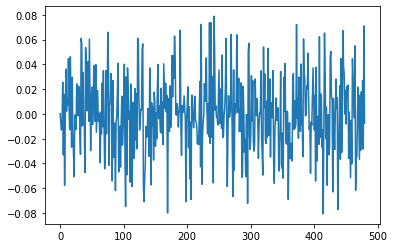

In [98]:
plt.plot(df_interp.zonal_velocity_hat_interp.dropna().values.compute())

In [ ]:
def interp_sig(_df, dsi,v,time,method=None,part=None):
    idw_eta, neighbors = [],[]
    idw_eta_mid, neighbors_mid = [],[]
    
    for it in range(0,_df.index.values.size):
    #for t in time
        mesh = pyinterp.RTree()
        _dsi = dsi.isel(time=it)#
        if part=='real':
            var = np.real(_dsi[v].values)
        elif part=='imag':
            var = np.imag(_dsi[v].values)
        else:
            var = _dsi[v].values
        mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                                _dsi.YC.values.flatten())).T,
                         var.flatten(),
                        )
        if method:
            idw_eta.append(mesh.radial_basis_function(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,  
                    num_threads=0,
                    rbf=method)[0])
            neighbors.append(mesh.radial_basis_function(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,
                    num_threads=0,
                    rbf=method)[1])
            idw_eta_mid.append(mesh.radial_basis_function(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4, 
                        num_threads=0,
                        rbf=method)[0])
            neighbors_mid.append(mesh.radial_basis_function(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4,  
                        num_threads=0,
                        rbf=method)[1])
        else:    
            idw_eta.append(mesh.inverse_distance_weighting(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,  
                    num_threads=0)[0])
            neighbors.append(mesh.inverse_distance_weighting(
                    np.vstack((_df.lon[it], _df.lat[it])).T,
                    within=True,
                    radius=None,
                    k=4,  
                    num_threads=0)[1])
            idw_eta_mid.append(mesh.inverse_distance_weighting(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4,  
                        num_threads=0)[0])
            neighbors_mid.append(mesh.inverse_distance_weighting(
                        np.vstack((np.real(_df.lon[time.size//2]), np.real(_df.lat[time.size//2]))).T,
                        within=True,
                        radius=None,
                        k=4,  
                        num_threads=0)[1])
    interp = idw_eta[0]
    for i in idw_eta[1:]:
        interp = np.insert(i,-1,interp)
    interp_mid = idw_eta_mid[0]
    for i in idw_eta_mid[1:]:
        interp_mid = np.insert(i,-1,interp_mid)
    return interp, interp_mid

In [ ]:
v = 'zonal_velocity_hat'
interp_hatr,interp_mid_hatr = interp_sig(_df1,dsi,v,_df1.index.values,part='real')
interp2_hatr,interp_mid2_hatr = interp_sig(_df2,dsi,v,_df2.index.values,part='real')



In [28]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
